In [5]:
import sys
import os
from glob import glob

import scanpy as sc

import seaborn as sns

import pandas as pd
import numpy as np

import PyComplexHeatmap as ch

import matplotlib.pylab as plt

from sklearn.metrics import balanced_accuracy_score, f1_score, matthews_corrcoef, recall_score, precision_score

from pyprojroot import here

import warnings
warnings.filterwarnings("ignore")

sys.path.insert(1, str(here('bin')))
from customPythonFunctions import getClassMetricsDF

from customPalette import annotation_Level1_palette, annotation_Level1_LowQFilt_sortednames

from PyComplexHeatmap import *
import warnings

from customPalette import diseases_palette, diseaseCategories, diseasesGroup_palette


In [6]:
cell_type_order = [c for c in annotation_Level1_LowQFilt_sortednames if c not in ['Cycling_cells','Progenitors','Platelets','RBC']]

In [7]:
optimization_metric = 'F1'

In [8]:
diseaseCategories['Na'] = 'Na'
diseasesGroup_palette['Na'] = '#ffffff'

### Computing additional metrics

In [9]:
def get_add_metric(disease_true, disease_pred):
    from sklearn.metrics import confusion_matrix
    
    disease_true = np.array(disease_true)
    disease_pred = np.array(disease_pred)
    res = []
    for d in np.unique(disease_true):
        support = (disease_true==d).sum()
        
        tn, fp, fn, tp = confusion_matrix(disease_true==d, disease_pred==d).ravel()
    
    
        prec = (tp / (tp+fp))
        recall = (tp / (tp+fn))
        specificity = (tn / (tn+fp))
        
        res.append([d, prec, recall, specificity, support])
    
    res = pd.DataFrame(res).fillna(0).set_index(0)
    Wprecision = np.average(res.loc[:,1], weights= res.loc[:,4])
    Wrecall = np.average(res.loc[:,2], weights= res.loc[:,4])
    Wspecifitity = np.average(res.loc[:,3], weights= res.loc[:,4])
    return (Wprecision,Wrecall,Wspecifitity)

### Defining integration parameters

In [39]:
integration_method = 'HS'
query_dataset = 'EXTERNAL'
embedded_space = 'cell'
n_embedded = 20
n_Patient_embedded = 0
batch_key = 'chemistry'
annotation = 'notUsed'
bestClf_family = 'SVC'

In [40]:
M_dir= f"03_downstream_analysis/09_patient_classifier/Classifiers/furtherPlots/{query_dataset}_{integration_method}_{n_embedded}_{n_Patient_embedded}"
os.makedirs(here(M_dir), exist_ok=True)

In [41]:
with open(here(f"{M_dir}/info.txt"), 'w') as f:
    f.writelines(f"integration_method = {integration_method}\n")
    f.writelines(f"query_dataset = {query_dataset}\n")
    f.writelines(f"embedded_space = {embedded_space}\n")
    f.writelines(f"n_embedded = {n_embedded}\n")
    f.writelines(f"n_Patient_embedded = {n_Patient_embedded}\n")
    f.writelines(f"batch_key = {batch_key}\n")
    f.writelines(f"annotation = {annotation}\n")
    f.writelines(f"bestClf_family = {bestClf_family}\n")
    f.writelines("\n")

### Loading results

#### Loading true and predicted labels

In [42]:
labels_df_dir= here(f'03_downstream_analysis/09_patient_classifier/Classifiers/results_CT_studies/label_predicted_dataframes/')
if integration_method in ['HS', 'scGen']:
    pt_i = os.path.join(labels_df_dir,f"{integration_method}_{embedded_space}_{n_embedded}nEmb_{n_Patient_embedded}nPEmb_{batch_key}_{annotation}_optF1_{bestClf_family}_{query_dataset}.pkl")
else:
    pt_i = os.path.join(labels_df_dir,f"{integration_method}_{embedded_space}_{n_embedded}nEmb_{n_Patient_embedded}nPEmb_{batch_key}_{annotation}_optF1_{query_dataset}_{bestClf_family}.pkl")

In [43]:
labels_df = pd.read_pickle(pt_i)
labels_df.rename({'majority_pred':'Majority vote', 'disease':'disease_true'}, axis=1, inplace=True)
labels_df.columns = [c.replace('disease_pred_','') for c in labels_df.columns]
labels_df

,B,DC,ILC,Mono,Plasma,T_CD4_Naive,T_CD4_NonNaive,T_CD8_Naive,T_CD8_NonNaive,UTC,pDC,Majority vote,disease_true
sampleID,,,,,,,,,,,,,
10XGenomics_10XHC1_T0,NPC,HNSCC,HNSCC,healthy,NPC,healthy,healthy,healthy,healthy,healthy,healthy,healthy,healthy
10XGenomics_10XHC2_T0,NPC,HNSCC,HNSCC,healthy,SLE,healthy,NPC,healthy,healthy,healthy,healthy,healthy,healthy
10XGenomics_10XHC3_T0,NPC,healthy,healthy,healthy,SLE,NPC,NPC,NPC,HBV,NPC,HNSCC,NPC,healthy
10XGenomics_10XHC4_T0,NPC,healthy,healthy,healthy,healthy,healthy,healthy,healthy,healthy,NPC,healthy,healthy,healthy
10XGenomics_10XHC5_T0,HNSCC,healthy,HNSCC,healthy,SLE,healthy,healthy,healthy,healthy,healthy,healthy,healthy,healthy
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Savage2021_BRISL5_T0,HNSCC,HNSCC,HNSCC,COVID,HNSCC,HNSCC,COVID,COVID,COVID,COVID,HNSCC,HNSCC,SLE
Savage2021_BRISL6_T0,HNSCC,HNSCC,HNSCC,healthy,HNSCC,healthy,HNSCC,healthy,HNSCC,HNSCC,healthy,HNSCC,SLE
Savage2021_BRISL7_T0,HNSCC,HNSCC,HNSCC,HNSCC,HNSCC,healthy,NPC,healthy,healthy,HBV,healthy,HNSCC,SLE


**Considering all samples**

In [44]:
print(f"Majority Voting BAS: {balanced_accuracy_score(y_pred=labels_df['Majority vote'], y_true=labels_df.disease_true)}")
print(f"Majority Voting Weighetd F1: {f1_score(y_pred=labels_df['Majority vote'], y_true=labels_df.disease_true, average='weighted')}")
print(f"Majority Voting MCC: {matthews_corrcoef(y_pred=labels_df['Majority vote'], y_true=labels_df.disease_true)}")

# Additional metrics
Wprecision,Wrecall,Wspecifitity = get_add_metric(disease_pred=labels_df['Majority vote'], disease_true= labels_df.disease_true)

print(f"Majority Voting Weighet precision: {Wprecision}")
print(f"Majority Voting Weighet recall: {Wrecall}")
print(f"Majority Voting Weighet specificity: {Wspecifitity}")

Majority Voting BAS: 0.24318321078431374
Majority Voting Weighetd F1: 0.4700724361418223
Majority Voting MCC: 0.3808385832209832
Majority Voting Weighet precision: 0.4625656414103526
Majority Voting Weighet recall: 0.5
Majority Voting Weighet specificity: 0.9333117070767813


In [45]:
with open(here(f"{M_dir}/info.txt"), 'a') as f:
    f.writelines(f"Majority Voting BAS: {balanced_accuracy_score(y_pred=labels_df['Majority vote'], y_true=labels_df.disease_true)}\n")
    f.writelines(f"Majority Voting Weighetd F1: {f1_score(y_pred=labels_df['Majority vote'], y_true=labels_df.disease_true, average='weighted')}\n")


In [46]:
labels_df.isna().sum()

B                 0
DC                0
ILC               0
Mono              0
Plasma            5
T_CD4_Naive       0
T_CD4_NonNaive    0
T_CD8_Naive       0
T_CD8_NonNaive    0
UTC               0
pDC               9
Majority vote     0
disease_true      0
dtype: int64

In [47]:
if embedded_space == 'sample':
    labelsMelt = labels_df.melt(value_vars = ['sample', 'Majority vote'], 
                                id_vars = ['disease_true'], 
                                var_name = 'cell_type', value_name= 'disease_pred', ignore_index=False).reset_index()
    labelsMelt['disease_true'] = labelsMelt['disease_true'].astype(str)
    labelsMelt
else:
    labelsMelt = labels_df.melt(value_vars = ['B', 'DC', 'ILC', 'Mono', 'Plasma', 'T_CD4_Naive', 'T_CD4_NonNaive',
                                              'T_CD8_Naive', 'T_CD8_NonNaive', 'UTC', 'pDC', 'Majority vote'], 
                                id_vars = ['disease_true'], 
                                var_name = 'cell_type', value_name= 'disease_pred', ignore_index=False).reset_index()
    labelsMelt['disease_true'] = labelsMelt['disease_true'].astype(str)
labelsMelt   

,sampleID,disease_true,cell_type,disease_pred
0,10XGenomics_10XHC1_T0,healthy,B,NPC
1,10XGenomics_10XHC2_T0,healthy,B,NPC
2,10XGenomics_10XHC3_T0,healthy,B,NPC
3,10XGenomics_10XHC4_T0,healthy,B,NPC
4,10XGenomics_10XHC5_T0,healthy,B,HNSCC
...,...,...,...,...
1027,Savage2021_BRISL5_T0,SLE,Majority vote,HNSCC
1028,Savage2021_BRISL6_T0,SLE,Majority vote,HNSCC
1029,Savage2021_BRISL7_T0,SLE,Majority vote,HNSCC
1030,Savage2021_PIDA_T0,healthy,Majority vote,healthy


### Table with F1, precision, recall, and accuracy score per class

In [48]:
MetricsDF = getClassMetricsDF(data = labelsMelt.fillna('na'), 
                              y_true_cn='disease_true', y_pred_cn='disease_pred', cell_type_cn='cell_type', 
                              disease_list=[d for d in diseases_palette.keys() if (d in labelsMelt.disease_true.unique())], 
                              include_aggregated=False)
MetricsDF.head()

,metric,stratification,healthy,RA,CD,SLE,cirrhosis,sepsis,HIV,COVID
0,recall_score,B,0.235294,0.75000,0.0,0.166667,0.0,0.0,0.0,0.00
1,recall_score,DC,0.529412,0.90625,0.0,0.166667,0.0,0.0,0.0,0.00
2,recall_score,ILC,0.470588,0.37500,0.0,0.333333,0.0,0.0,0.0,0.00
3,recall_score,Mono,0.823529,0.43750,0.0,0.166667,0.0,0.0,0.0,0.25
4,recall_score,Plasma,0.352941,0.40625,0.0,0.000000,0.0,0.0,0.0,0.25


In [49]:
if query_dataset == 'EXTERNAL':
    experiment = 'unseenStudies'
else:
    experiment = 'unseenPatients'

if integration_method == 'scPoli':
    with pd.ExcelWriter(here('03_downstream_analysis/metricXdisease.xlsx'), mode = 'a', if_sheet_exists = 'replace') as writer:  
        MetricsDF.to_excel(writer, sheet_name=f'PatCl_{experiment}_{integration_method}_{embedded_space}_cellEmbDim{n_embedded}_patEmbDim{n_Patient_embedded}', index_label=None, index=False)
else:
    with pd.ExcelWriter(here('03_downstream_analysis/metricXdisease.xlsx'), mode = 'a', if_sheet_exists = 'replace') as writer:  
        MetricsDF.to_excel(writer, sheet_name=f'PatCl_{experiment}_{integration_method}_embDim{n_embedded}', index_label=None, index=False)

In [52]:
MetricsDF.to_csv(os.path.join(here(M_dir), 'metricsXdisease.csv'))

In [21]:
print(f"overall BAS for cell-type: {balanced_accuracy_score(labelsMelt.loc[labelsMelt['cell_type'] != 'Majority vote','disease_true'].astype(str),labelsMelt.loc[labelsMelt['cell_type'] != 'Majority vote','disease_pred'].astype(str))}")

print(f"overall W F1 for cell-type: {f1_score(labelsMelt.loc[labelsMelt['cell_type'] != 'Majority vote','disease_true'].astype(str), labelsMelt.loc[labelsMelt['cell_type'] != 'Majority vote','disease_pred'].astype(str), average='weighted')}")

print(f"overall MCC for cell-type: {matthews_corrcoef(labelsMelt.loc[labelsMelt['cell_type'] != 'Majority vote','disease_true'].astype(str),labelsMelt.loc[labelsMelt['cell_type'] != 'Majority vote','disease_pred'].astype(str))}")



overall BAS for cell-type: 0.17175662878787878
overall W F1 for cell-type: 0.3602553607103618
overall MCC for cell-type: 0.21609670344521173


In [22]:
print(f" Number of patients that were not classified due to undetermined majority vote result: {(labels_df['Majority vote'] == 'nan').sum()}")

 Number of patients that were not classified due to undetermined majority vote result: 2


### Weighted F1, Balanced Accuracy Score, Matthew coefficent score

We compute those metrics for each cell-type, balacing the conditions

In [23]:
cell_type_WF1 = (labelsMelt.groupby(['cell_type'])[['disease_true','disease_pred']]
                 .apply(lambda x: (f1_score(x.disease_true.astype(str),
                                           x.disease_pred.astype(str), average='weighted')))
                ).reset_index()
cell_type_WF1.rename({0:'W_F1'}, axis = 1, inplace=True)

In [24]:
cell_type_bas = (labelsMelt.groupby(['cell_type'])[['disease_true','disease_pred']]
                 .apply(lambda x: (balanced_accuracy_score(x.disease_true.astype(str), 
                                                           x.disease_pred.astype(str))))
                ).reset_index()
cell_type_bas.rename({0:'BAS'}, axis = 1, inplace=True)


### F1, Precision, Recall

We compute those metrics for each cell-type and each condition 

In [25]:
cell_type_F1 = (labelsMelt.groupby(['cell_type'])[['disease_true','disease_pred']]
                 .apply(lambda x: (f1_score(y_true = x.disease_true.astype(str), 
                                            y_pred = x.disease_pred.astype(str), labels=x.disease_true.unique(), average=None)))
                ).reset_index()
cell_type_F1.columns = ['cell_type','F1']
cell_type_F1['disease_true'] = [labelsMelt.disease_true.unique().tolist()]*cell_type_F1.shape[0]
cell_type_F1 = cell_type_F1.explode(['F1','disease_true'])

## Visualization

In [26]:
# ordering elements
labelsMelt.disease_pred = labelsMelt.disease_pred.astype(str)
labelsMelt.disease_pred[labelsMelt.disease_pred == 'nan'] = 'Na'

elementList =  [d for d in set(labelsMelt.disease_true.tolist() + labelsMelt.disease_pred.tolist()) if (d != 'healthy' and d!='Na')]
diseaseCatOrd = [diseaseCategories[d] for d in elementList]

sortedIdx = sorted(range(len(diseaseCatOrd)), key=lambda index: diseaseCatOrd[index])

disease_cat_ordDF = pd.DataFrame.from_dict({'elementList':elementList,'diseaseCatOrd':[diseaseCategories[d] for d in elementList]})
disease_cat_ordDF = pd.concat((pd.DataFrame.from_dict({'elementList':['healthy'], 'diseaseCatOrd':['healthy']}), 
                               disease_cat_ordDF.iloc[sortedIdx,:].groupby('diseaseCatOrd').apply(lambda x: x.sort_values('elementList')).reset_index(drop=True),
                              pd.DataFrame.from_dict({'elementList':['Na'], 'diseaseCatOrd':['Na']})),
                              axis=0)

**Scatterplot over cell types**

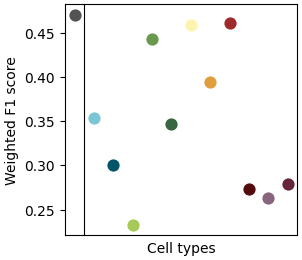

In [28]:
if embedded_space !='sample':
    plt.figure(figsize=(3,3))
    g = sns.pointplot(cell_type_WF1, 
                x = 'cell_type', 
                hue = 'cell_type', 
                y = 'W_F1', 
                palette  = annotation_Level1_palette | {'Majority vote':'#535353'},
                   order=['Majority vote'] + cell_type_order)

    g.axvline(x=0.5, ymin=0, ymax=1, c="black", ls='-', linewidth=0.8, zorder=0, clip_on=False)

    g.set_xticks([], [])
    
    plt.ylabel('Weighted F1 score')
    plt.xlabel('Cell types')
    # plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=2, fancybox=True)
    plt.xticks(rotation=90)
    
    plt.savefig(here(f"{M_dir}/referencebalanced_WF1_CTxDisease.pdf"),
    dpi=300,
    bbox_inches='tight',
    pad_inches=0.1
    )
    plt.show()

**Score for each cell-type and disease**

after aggregating the prediction on each left-out split 

In [29]:
import string

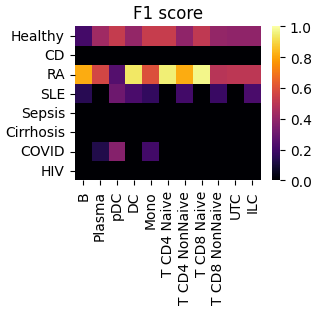

In [30]:
data = cell_type_F1.query("cell_type != 'Majority vote'").pivot(columns='disease_true', index = 'cell_type', values = 'F1').T.fillna(0)
if embedded_space !='sample':

    plt.figure(figsize=(3,2))
    
    g = sns.heatmap(data.loc[disease_cat_ordDF.elementList[disease_cat_ordDF.elementList.isin(data.index.tolist())],
                    cell_type_order],square=False,vmin=0,vmax=1,cmap='inferno')

    g.set_xticks(g.get_xticks(), [t.get_text().replace('_',' ') for t in g.get_xticklabels()])
    g.set_yticks(g.get_yticks(), [[l[0].upper() + l[1:] for l in t.get_text().split()][0] for t in g.get_yticklabels()])

    g.set_title('F1 score')
    g.set_xlabel("")
    g.set_ylabel("")
    
    plt.savefig(here(f"{M_dir}/clusterMap_F1_CTxDisease_noMV.pdf"),
    dpi=300,
    bbox_inches='tight',
    pad_inches=0.1
    )

### Confusion Matrix

#### Functions

In [26]:
# Computing the confusion matrix
def getConfusionMatrix(predTestDF = None, predCol = 'y_pred', gtCol = 'y_test', normalize='columns'):

    # normalize could be False, 'rows', or 'columns' (default).
    
    import pandas as pd

    if normalize == False:
        confusionMatrix = pd.crosstab(predTestDF[predCol], predTestDF[gtCol], dropna=False)
    else:
        confusionMatrix = pd.crosstab(predTestDF[predCol], predTestDF[gtCol], normalize=normalize, dropna=False)

    if confusionMatrix.shape[0] < confusionMatrix.shape[1]:
        for d in np.setdiff1d(confusionMatrix.columns.tolist(), confusionMatrix.index.tolist()):
            confusionMatrix.loc[d,:] = 0
    elif confusionMatrix.shape[0] > confusionMatrix.shape[1]:
        for d in np.setdiff1d(confusionMatrix.index.tolist(),confusionMatrix.columns.tolist()):
            confusionMatrix[d] = 0   

    return(confusionMatrix)

In [27]:
def reorder_ConfMatrix(confusionMatrix=None, elementList = None):

    confusionMatrix = confusionMatrix.reindex(elementList, axis=0).reindex(elementList, axis=1)

    return(confusionMatrix)

In [28]:
def mask_entries(confusionMatrix=None, lowerThan = 0, cmap='viridis'):
    confusionMatrix_nan = confusionMatrix.copy()
    confusionMatrix_nan[confusionMatrix_nan <= lowerThan] = np.nan
    return(confusionMatrix_nan)
    

#### Changing the PyComplexHeatmap code

https://dingwb.github.io/PyComplexHeatmap/build/html/notebooks/composite_heatmaps.html#Composite-two-heatmaps-horizontally-for-mouse-DNA-methylation-array-dataset

The following change is required to avoid reordering columns and rows. So, disease in the same category are close to each others

In [29]:
def _reorder_rows(self):
    self.row_split_dendrogram = False
    if self.verbose >= 1:
        print("Reordering rows..")
    if self.row_split is None and self.row_cluster:
        self.calculate_row_dendrograms(
            self.data2d
        )  # xind=self.dendrogram_row.reordered_ind
        self.row_order = [
            self.dendrogram_row.dendrogram["ivl"]
        ]  # self.data2d.iloc[:, xind].columns.tolist()
        return None
    elif isinstance(self.row_split, int) and self.row_cluster:
        self.calculate_row_dendrograms(self.data2d)
        self.row_clusters = (
            pd.Series(
                hierarchy.fcluster(
                    self.dendrogram_row.linkage,
                    t=self.row_split,
                    criterion="maxclust",
                ),
                index=self.data2d.index.tolist(),
            )
            .to_frame(name="cluster")
            .groupby("cluster")
            .apply(lambda x: x.index.tolist())
            .to_dict()
        )
        # index=self.dendrogram_row.dendrogram['ivl']).to_frame(name='cluster')

    elif isinstance(self.row_split, (pd.Series, pd.DataFrame)):
        if isinstance(self.row_split, pd.Series):
            self.row_split = self.row_split.to_frame(name=self.row_split.name)
        cols = self.row_split.columns.tolist()
        row_clusters = self.row_split.groupby(cols, sort=False).apply(
            lambda x: x.index.tolist()
        )
        if self.row_split_order is None:
            self.row_split_order = row_clusters.index.tolist()
        elif self.row_split_order == 'cluster_between_groups':
            mat=pd.concat([
                self.data2d.loc[rows].mean() for rows in row_clusters.tolist()],
                          axis=1).T #columns are original columns
            mat.index=row_clusters.index.tolist()
            sizes=row_clusters.apply(lambda x:len(x)).tolist()
            self.calculate_row_dendrograms(mat,sizes=sizes)
            self.row_split_order = self.dendrogram_row.dendrogram["ivl"]
            self.row_split_dendrogram=self.dendrogram_row
        self.row_clusters = row_clusters.loc[self.row_split_order].to_dict()
    elif not self.row_cluster:
        self.row_order = [self.data2d.index.tolist()]
        return None
    else:
        raise TypeError("row_split must be integar or dataframe or series")

    self.row_order = []
    self.dendrogram_rows = []
    for i, cluster in enumerate(self.row_clusters):
        rows = self.row_clusters[cluster]
        if len(rows) <= 1:
            self.row_order.append(rows)
            self.dendrogram_rows.append(None)
            continue
        if self.row_cluster: #cluster within groups
            self.calculate_row_dendrograms(self.data2d.loc[rows])
            self.dendrogram_rows.append(self.dendrogram_row)
            self.row_order.append(self.dendrogram_row.dendrogram["ivl"])
        else:
            self.row_order.append(rows)

def _reorder_cols(self):
    self.col_split_dendrogram=False
    if self.verbose >= 1:
        print("Reordering cols..")
    if self.col_split is None and self.col_cluster:
        self.calculate_col_dendrograms(self.data2d)
        self.col_order = [
            self.dendrogram_col.dendrogram["ivl"]
        ]  # self.data2d.iloc[:, xind].columns.tolist()
        return None
    elif isinstance(self.col_split, int) and self.col_cluster:
        self.calculate_col_dendrograms(self.data2d)
        self.col_clusters = (
            pd.Series(
                hierarchy.fcluster(
                    self.dendrogram_col.linkage,
                    t=self.col_split,
                    criterion="maxclust",
                ),
                index=self.data2d.columns.tolist(),
            )
            .to_frame(name="cluster")
            .groupby("cluster")
            .apply(lambda x: x.index.tolist())
            .to_dict()
        )
        # index=self.dendrogram_col.dendrogram['ivl']).to_frame(name='cluster')

    elif isinstance(self.col_split, (pd.Series, pd.DataFrame)):
        if isinstance(self.col_split, pd.Series):
            self.col_split = self.col_split.to_frame(name=self.col_split.name)
        cols = self.col_split.columns.tolist()
        col_clusters = self.col_split.groupby(cols, sort=False).apply(
            lambda x: x.index.tolist()
        )
        if self.col_split_order is None:
            self.col_split_order = col_clusters.index.tolist()
        elif self.col_split_order == 'cluster_between_groups':
            mat = pd.concat([
                self.data2d.loc[:,cols].mean(axis=1) for cols in col_clusters.tolist()],
                axis=1)  # index are original rows labels
            mat.columns = col_clusters.index.tolist()
            sizes = col_clusters.apply(lambda x: len(x)).tolist()
            self.calculate_col_dendrograms(mat, sizes=sizes)
            self.col_split_order = self.dendrogram_col.dendrogram["ivl"]
            self.col_split_dendrogram = self.dendrogram_col
        self.col_clusters = col_clusters.loc[self.col_split_order].to_dict()
    elif not self.col_cluster:
        self.col_order = [self.data2d.columns.tolist()]
        return None
    else:
        raise TypeError("row_split must be integar or dataframe or series")

    self.col_order = []
    self.dendrogram_cols = []
    for i, cluster in enumerate(self.col_clusters):
        cols = self.col_clusters[cluster]
        if len(cols) <= 1:
            self.col_order.append(cols)
            self.dendrogram_cols.append(None)
            continue
        if self.col_cluster:
            self.calculate_col_dendrograms(self.data2d.loc[:, cols])
            self.dendrogram_cols.append(self.dendrogram_col)
            self.col_order.append(self.dendrogram_col.dendrogram["ivl"])
        else:
            self.col_order.append(cols)

def plot_matrix(self, row_order, col_order):
    col_order=row_order.copy()
    if self.verbose >= 1:
        print("Plotting matrix..")
    nrows = len(row_order)
    ncols = len(col_order)
    self.wspace = (
        self.col_split_gap
        * mm2inch
        * self.ax.figure.dpi
        / (self.ax_heatmap.get_window_extent().width / ncols)
    )  # 1mm=mm2inch inch
    self.hspace = (
        self.row_split_gap
        * mm2inch
        * self.ax.figure.dpi
        / (self.ax_heatmap.get_window_extent().height / nrows)
    )  # height
    self.heatmap_gs = matplotlib.gridspec.GridSpecFromSubplotSpec(
        nrows,
        ncols,
        hspace=self.hspace,
        wspace=self.wspace,
        subplot_spec=self.gs[1, 1],
        height_ratios=[len(rows) for rows in row_order],
        width_ratios=[len(cols) for cols in col_order],
    )

    annot = self.kwargs.pop("annot", None)
    if annot is None or annot is False:
        pass
    else:
        if isinstance(annot, bool):
            annot_data = self.data2d
        else:
            annot_data = annot.copy()
            if annot_data.shape != self.data2d.shape:
                err = "`data` and `annot` must have same shape."
                raise ValueError(err)

    self.heatmap_axes = np.empty(shape=(nrows, ncols), dtype=object)
    # if nrows > 1 or ncols > 1:
    self.ax_heatmap.set_axis_off()
    for i, rows in enumerate(row_order):
        for j, cols in enumerate(col_order):
            # print(i,j)
            ax1 = self.ax_heatmap.figure.add_subplot(
                self.heatmap_gs[i, j],
                sharex=self.heatmap_axes[0, j],
                sharey=self.heatmap_axes[i, 0],
            )
            ax1.set_xlim([0, len(rows)])
            ax1.set_ylim([0, len(cols)])
            annot1 = None if annot is None else annot_data.loc[rows, cols]
            # heatmap(self.data2d.loc[rows, cols], ax=ax1, cbar=False, cmap=self.cmap,
            #         cbar_kws=None, mask=self.mask.loc[rows, cols], rasterized=self.rasterized,
            #         xticklabels='auto', yticklabels='auto', annot=annot1, **self.kwargs)
            plot_heatmap(
                self.data2d.loc[rows, cols],
                ax=ax1,
                cmap=self.cmap,
                mask=self.mask.loc[rows, cols],
                rasterized=self.rasterized,
                xticklabels="auto",
                yticklabels="auto",
                annot=True,
                **self.kwargs
            )
            self.heatmap_axes[i, j] = ax1
            ax1.yaxis.label.set_visible(False)
            ax1.xaxis.label.set_visible(False)
            ax1.tick_params(
                left=False,
                right=False,
                labelleft=False,
                labelright=False,
                top=False,
                bottom=False,
                labeltop=False,
                labelbottom=False,
            )


In [30]:
ClusterMapPlotter._reorder_rows = _reorder_rows
ClusterMapPlotter._reorder_cols = _reorder_cols
# ClusterMapPlotter.plot_matrix = plot_matrix

In [31]:
MajorityVote_confusionMatrix = getConfusionMatrix(predTestDF= labelsMelt.query("cell_type == 'Majority vote'"), predCol = 'disease_pred', gtCol = 'disease_true', normalize='columns')
MajorityVote_confusionMatrix_ord = reorder_ConfMatrix(mask_entries(MajorityVote_confusionMatrix, lowerThan = -1), elementList=disease_cat_ordDF.elementList)

In [32]:
MajorityVote_confusionMatrix_ord[MajorityVote_confusionMatrix_ord == 0.0] = np.nan
MajorityVote_confusionMatrix_ord = MajorityVote_confusionMatrix_ord.dropna(how='all').dropna(how='all', axis=1).fillna(0)

In [33]:
# rows
rowConditions = MajorityVote_confusionMatrix_ord.index.tolist()
rowAnnDF = pd.DataFrame.from_dict({'disease_cat' : [diseaseCategories[c] for c in rowConditions], 'disease':rowConditions}).set_index('disease')
row_ann = HeatmapAnnotation(disease_group=anno_simple(rowAnnDF.disease_cat, colors=diseasesGroup_palette, rasterized=True, legend_kws={'color_text':False, 'labelcolor':'black'}),#, legend_kws  = {'title': 'Disease\ngroups'}), 
                            axis=0,verbose=0, label_kws={'text':None}, plot=False, legend=False)

# columns
colConditions = MajorityVote_confusionMatrix_ord.columns.tolist()
colAnnDF = pd.DataFrame.from_dict({'disease_cat' : [diseaseCategories[c] for c in colConditions], 'disease':colConditions}).set_index('disease')
col_ann = HeatmapAnnotation(disease_group=anno_simple(colAnnDF.disease_cat, colors=diseasesGroup_palette, rasterized=True, legend_kws={'color_text':False, 'labelcolor':'black'}),#, legend_kws  = {'title': 'Disease\ngroups'}), 
                            axis=1,verbose=0, label_kws={'text':None}, plot=False, legend=False)

Incresing ncol


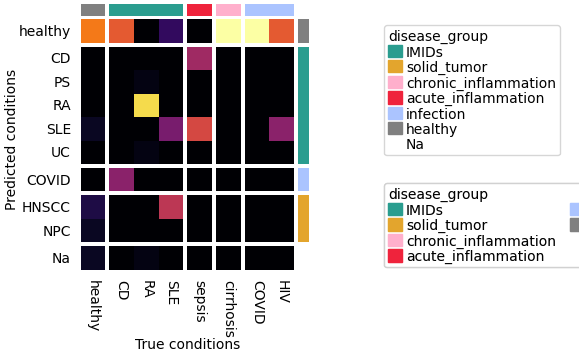

In [35]:
plt.figure(figsize=(3, MajorityVote_confusionMatrix_ord.shape[0] * .35))
cm = ClusterMapPlotter(data=MajorityVote_confusionMatrix_ord.fillna(0), 
                       right_annotation=row_ann, 
                       top_annotation=col_ann, 
                       row_split=rowAnnDF.disease_cat, #row_split_order=diseaseCatOrd,
                       col_split=colAnnDF.disease_cat, #col_split_order=diseaseCatOrd,
                       show_rownames=True,show_colnames=True, xlabel = 'True conditions', ylabel = 'Predicted conditions',
                       plot=True, fmt=None,
                       row_cluster=False, col_cluster=False, standard_scale = None,
                       row_dendrogram=False,col_dendrogram=False, verbose=False,
                       cmap='inferno', rasterized=False, 
                       row_split_gap=1, col_split_gap=1, legend=False, label = 'Proportion\n(col norm)', legend_vpad=5,
                       vmax = 1, vmin = 0)

plt.savefig(here(f"{M_dir}/MajorityVote_confusionMatrix.pdf"),
dpi=300,
bbox_inches='tight',
pad_inches=0.1
)